Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [z_steps]
>Slice: [z_0]
Sampling chain 0, 0 divergences: 100%|██████████| 3000/3000 [03:39<00:00, 13.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


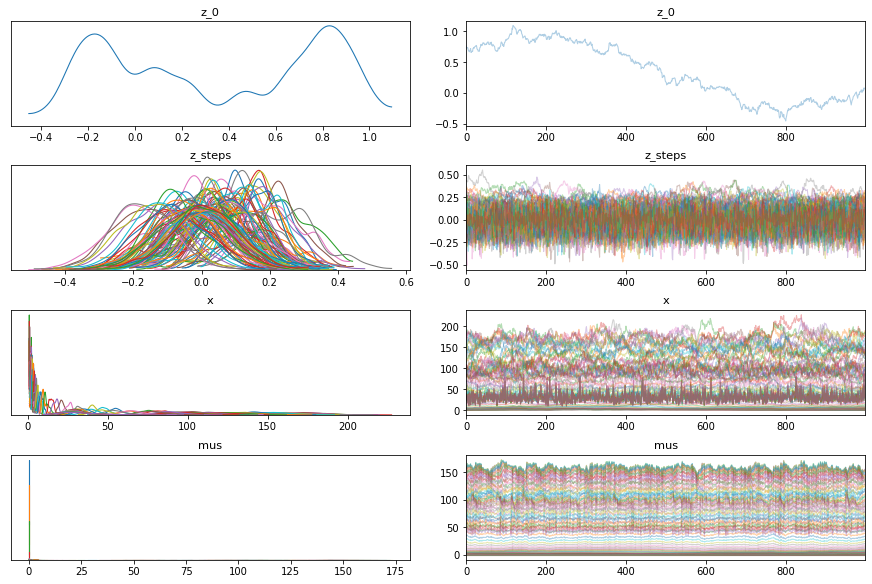

In [31]:
# coding: utf-8

import math
import random
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from theano.compile.ops import as_op

# 2020/1/25〜5/9の東京都の陽性者数（累計）
y_cum =[
2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,6,14,19,19,22,25,25,28,29,29,
32,32,35,36,36,37,39,39,40,44,52,58,64,64,64,67,73,75,77,87,90,90,102,
111,118,129,136,138,154,171,212,259,299,362,430,443,521,587,684,773,889,
1032,1115,1194,1338,1516,1703,1900,2066,2157,2316,2442,2590,2791,2972,3079,
3181,3304,3436,3570,3731,3834,3906,3945,4057,4104,4150,4315,4473,4564,4651,
4709,4747,4770,4809,4845
]

y_cum = np.array(y_cum)
y = np.diff(y_cum)
N = len(y)

M=63
kernel = np.zeros((M,))
lambd=14
tot = 0
for k in range(M):
    fk = lambd**k / math.factorial(k)
    tot += fk
    kernel[k] = fk
kernel = kernel/tot
kernel = np.roll(kernel, M//2)
    
@as_op(itypes=[tt.dvector],otypes=[tt.dvector])
def convolve(x):
    return np.convolve(x,kernel,mode='same')

model = pm.Model()
with model:
    z_0 = pm.Normal('z_0')
    z_steps = pm.Normal('z_steps', sigma=0.1, shape=N-1)
    zs = tt.concatenate([[z_0], z_steps])
    z = zs.cumsum()
    x = pm.Deterministic('x',pm.math.exp(z))
    mus = pm.Deterministic('mus', convolve(x))
    cases = pm.Poisson('cases', mu=mus, observed=y)
    trace = pm.sample(chains=1, tune=2000, draws=1000)
    pm.traceplot(trace)

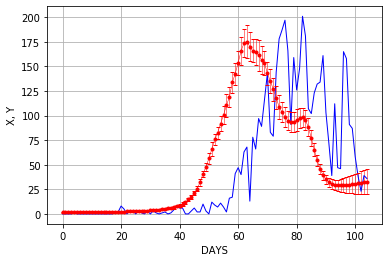

In [32]:
import matplotlib.pyplot as plt
xm = np.mean( trace['x'],axis=0)
xd = np.std( trace['x'],axis=0)

days=range(0,len(y))

plt.plot(days, y, color=(0.0,0.0,1.0), linewidth=1.0)
plt.errorbar(days, xm, yerr=xd, marker='.', color=(1.0,0.0,0.0), capthick=1, capsize=2, linewidth=0.5)

plt.xlabel('DAYS')
plt.ylabel('X, Y')
plt.grid(True)
plt.show()